# Main experiment notebook

This notebook is the main experiment and uses the following two files as its starting point.

**Files:**
- `output/expression_matrix_with_tp53_status_gambardella.h5ad`
- `output/expression_matrix_with_tp53_status_kinker.h5ad`

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import sys
import mygene
import anndata as ad
import scanpy as sc
import scipy
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

sys.path.append(os.path.abspath("../src"))
import preprocessing
import graph_constructor
import model_comparison

/opt/anaconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Header Inspection and Gene Manipulation for Gambardella

In [2]:
# Load only the headers of the Gambardella and Kinker expression matrices from .h5ad files to inspect their structure


gambardella_path = '../output/expression_matrix_gambardella_with_tp53_status.h5ad'
kinker_path = '../output/expression_matrix_kinker_with_tp53_status.h5ad'

# Read AnnData objects (do not load X matrix to save memory)
gambardella_adata = ad.read_h5ad(gambardella_path, backed='r')
kinker_adata = ad.read_h5ad(kinker_path, backed='r')

# Get gene columns (var) and obs columns
gambardella_genes = list(gambardella_adata.var_names)
kinker_genes = list(kinker_adata.var_names)

gambardella_obs_cols = list(gambardella_adata.obs.columns)
kinker_obs_cols = list(kinker_adata.obs.columns)

print(f'Gambardella: {len(gambardella_genes)} gene columns, {len(gambardella_obs_cols)} obs columns')
print(f'Kinker: {len(kinker_genes)} gene columns, {len(kinker_obs_cols)} obs columns')

# Show first 5 gene columns for each
print('Gambardella first 5 gene columns:', gambardella_genes[:5])
print('Kinker first 5 gene columns:', kinker_genes[:5])

# Show last 5 gene columns for each
print('Gambardella last 5 gene columns:', gambardella_genes[-5:])
print('Kinker last 5 gene columns:', kinker_genes[-5:])

# Show obs columns for each
print('Gambardella obs columns:', gambardella_obs_cols)
print('Kinker obs columns:', kinker_obs_cols)

# Close backed AnnData objects
gambardella_adata.file.close()
kinker_adata.file.close()

Gambardella: 47096 gene columns, 2 obs columns
Kinker: 30313 gene columns, 2 obs columns
Gambardella first 5 gene columns: ['ENSG00000000003', 'ENSG00000000419', 'ENSG00000000457', 'ENSG00000000460', 'ENSG00000001036']
Kinker first 5 gene columns: ['A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1']
Gambardella last 5 gene columns: ['ENSG00000279270', 'ENSG00000280920', 'ENSG00000283420', 'ENSG00000284003', 'ENSG00000284685']
Kinker last 5 gene columns: ['SPATA13', 'TBC1D26', 'TIMM10B', 'TMBIM4', 'TMEM256-PLSCR3']
Gambardella obs columns: ['Cell_line', 'TP53_status']
Kinker obs columns: ['Cell_line', 'TP53_status']


In [3]:
# Map Ensembl gene IDs in Gambardella and Kinker AnnData var_names to gene symbols using mygene, and create mappings

mg = mygene.MyGeneInfo()

# For Gambardella: Replace var_names with gene symbols in the AnnData object (in memory)
gambardella_adata = ad.read_h5ad(gambardella_path)
gambardella_genes = list(gambardella_adata.var_names)
gambardella_ensembl_ids = [gene for gene in gambardella_genes if gene.startswith('ENSG')]
gambardella_query = mg.querymany(gambardella_ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')
gambardella_id_to_symbol = {item['query']: item.get('symbol', None) for item in gambardella_query if 'symbol' in item}
# Replace Ensembl IDs with gene symbols where possible, otherwise keep the original ID
new_var_names = [gambardella_id_to_symbol.get(gene, gene) for gene in gambardella_genes]
gambardella_adata.var_names = new_var_names


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


KeyboardInterrupt: 

In [ ]:
# Check if previous cell (gene symbol mapping) went well by verifying AnnData var_names were updated
expected_type = str
if not all(isinstance(gene, expected_type) for gene in gambardella_adata.var_names):
    raise ValueError("Not all Gambardella var_names are strings after mapping. Previous cell may have failed.")

# Optionally, check for duplicates or missing values in var_names
if len(set(gambardella_adata.var_names)) != len(gambardella_adata.var_names):
    print("Warning: Duplicate gene symbols found in Gambardella var_names after mapping.")

# Get gene columns (var) and obs columns
gambardella_genes = list(gambardella_adata.var_names)
kinker_genes = list(kinker_adata.var_names)

gambardella_obs_cols = list(gambardella_adata.obs.columns)
kinker_obs_cols = list(kinker_adata.obs.columns)

print(f'Gambardella: {len(gambardella_genes)} gene columns, {len(gambardella_obs_cols)} obs columns')
print(f'Kinker: {len(kinker_genes)} gene columns, {len(kinker_obs_cols)} obs columns')

# Show first 5 gene columns for each
print('Gambardella first 5 gene columns:', gambardella_genes[:5])
print('Kinker first 5 gene columns:', kinker_genes[:5])

# Show last 5 gene columns for each
print('Gambardella last 5 gene columns:', gambardella_genes[-5:])
print('Kinker last 5 gene columns:', kinker_genes[-5:])

# Show obs columns for each
print('Gambardella obs columns:', gambardella_obs_cols)
print('Kinker obs columns:', kinker_obs_cols)

# Close backed AnnData objects
gambardella_adata.file.close()
kinker_adata.file.close()

Gambardella: 47096 gene columns, 2 obs columns
Kinker: 30313 gene columns, 2 obs columns
Gambardella first 5 gene columns: ['TSPAN6', 'DPM1', 'SCYL3', 'FIRRM', 'FUCA2']
Kinker first 5 gene columns: ['A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1']
Gambardella last 5 gene columns: ['OR52R1', 'ENSG00000280920', 'MIR4278', 'ENSG00000284003', 'ENSG00000284685']
Kinker last 5 gene columns: ['SPATA13', 'TBC1D26', 'TIMM10B', 'TMBIM4', 'TMEM256-PLSCR3']
Gambardella obs columns: ['Cell_line', 'TP53_status']
Kinker obs columns: ['Cell_line', 'TP53_status']


In [ ]:
# Salva il nuovo oggetto AnnData di Gambardella con i gene symbol come var_names
import os

output_dir = "../output"
os.makedirs(output_dir, exist_ok=True)  # Assicurati che la cartella esista

output_path = os.path.join(output_dir, "expression_matrix_gambardella_with_tp53_status_and_gene_symbols.h5ad")
gambardella_adata.write(output_path)
#print(f"Nuovo file Gambardella creato e salvato con gene symbols come var_names in '{output_path}'")


# Merging two dataset

## Target Gene Inspection

In [ ]:
# Load TP53 target genes and find their intersection with gene columns in Kinker and Gambardella datasets (using AnnData objects)

# Load TP53 target genes from Excel file
target_genes_df = pd.read_excel('../data/TP53target/41388_2017_BFonc2016502_MOESM5_ESM_tab1.xlsx')

# Use the "Gene Symbol" column for target genes
target_genes = set(target_genes_df["Gene Symbol"].astype(str).str.upper())

# Get gene columns from AnnData objects (var_names)
kinker_genes = set([gene.upper() for gene in kinker_adata.var_names])
gambardella_genes = set([gene.upper() for gene in gambardella_adata.var_names])

# Find intersection with target genes
kinker_targets = target_genes & kinker_genes
gambardella_targets = target_genes & gambardella_genes

print(f"Number of TP53 target genes in Kinker: {len(kinker_targets)}")
print(f"Number of TP53 target genes in Gambardella: {len(gambardella_targets)}")
print(f"Example in Kinker: {list(kinker_targets)[:10]}")
print(f"Example in Gambardella: {list(gambardella_targets)[:10]}")

Number of TP53 target genes in Kinker: 338
Number of TP53 target genes in Gambardella: 337
Example in Kinker: ['DSP', 'ECT2', 'RBPJ', 'GDF15', 'DRAM1', 'AGT', 'MYOG', 'TSC2', 'APOB', 'TGM2']
Example in Gambardella: ['DSP', 'ECT2', 'RBPJ', 'GDF15', 'DRAM1', 'AGT', 'MYOG', 'TSC2', 'APOB', 'TGM2']


## Compare Columns (Genes/Features)

Let's see the overlap and differences between the two datasets' columns.

In [ ]:
# Compare gene columns (var_names) between Gambardella and Kinker datasets to find shared and unique genes
gambardella_cols = set(gambardella_adata.obs.columns) | set(gambardella_adata.var_names)
kinker_cols = set(kinker_adata.obs.columns) | set(kinker_adata.var_names)

gene_cols_gambardella = set([gene.upper() for gene in gambardella_adata.var_names])
gene_cols_kinker = set([gene.upper() for gene in kinker_adata.var_names])

shared_genes = gene_cols_gambardella & gene_cols_kinker
unique_gambardella = gene_cols_gambardella - gene_cols_kinker
unique_kinker = gene_cols_kinker - gene_cols_gambardella

print(f'Shared genes: {len(shared_genes)}')
print(f'Unique to Gambardella: {len(unique_gambardella)}')
print(f'Unique to Kinker: {len(unique_kinker)}')

Shared genes: 18235
Unique to Gambardella: 28203
Unique to Kinker: 12078


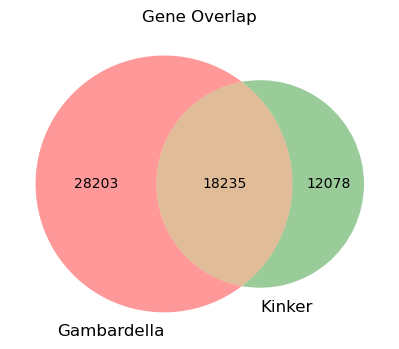

In [ ]:
# Visualize the gene overlap
from matplotlib_venn import venn2
plt.figure(figsize=(6,4))
venn2([gene_cols_gambardella, gene_cols_kinker], set_labels=('Gambardella', 'Kinker'))
plt.title('Gene Overlap')
plt.show()

## Inspect result of the merge

We used `jobs/merge_gambardella_kinker.sh` to merge the two datasets, `expression_matrix_gambardella_with_tp53_status_and_gene_symbol.h5ad` and `expression_matrix_kinker_with_tp53_status.h5ad`, resulting in `merged_gambardella_kinker.h5ad`. Now, we inspect the result.

In [ ]:
#Common dataset
import anndata as ad

# Load the merged file
adata_merged = ad.read_h5ad("../output/merged_gambardella_kinker_common_genes.h5ad")

# Show general information
print(adata_merged)

# Show the final shape of the expression matrix (cells x genes)
print(f"Final shape of the expression matrix (cells x genes): {adata_merged.shape}")

# Show the first rows of the cell annotations
display(adata_merged.obs.head())

# Show the first rows of the gene annotations
display(adata_merged.var.head())

# Count the number of cells per dataset (check that both origins are present)
print(adata_merged.obs['dataset'].value_counts())

AnnData object with n_obs × n_vars = 64943 × 18235
    obs: 'Cell_line', 'TP53_status', 'dataset'
Final shape of the expression matrix (cells x genes): (64943, 18235)


,Cell_line,TP53_status,dataset
AU565_AAACCAGTTTGG,AU565,Missense_Mutation,gambardella
AU565_AAACGTGCAGCG,AU565,Missense_Mutation,gambardella
AU565_AAAGCCACATGC,AU565,Missense_Mutation,gambardella
AU565_AAAGTCGGCTGG,AU565,Missense_Mutation,gambardella
AU565_AAAGTGCCTAAA,AU565,Missense_Mutation,gambardella


""
TSPAN6
DPM1
SCYL3
FUCA2
GCLC


dataset
kinker         38364
gambardella    26579
Name: count, dtype: int64


# EDA & Preprocessing (with feature selection: HVG)

In [3]:
adata_merged = ad.read_h5ad("../output/merged_gambardella_kinker_common_genes.h5ad")

In [ ]:
#Sparsity
# def check_sparsity(adata):
#     """Print sparsity info for AnnData object."""
#     print(f"Number of cells: {adata.shape[0]}")
#     print(f"Number of genes: {adata.shape[1]}")
#     print(f"Number of non-zero entries: {adata.X.nnz}")
#     print(f"Sparsity: {1 - (adata.X.nnz / (adata.shape[0] * adata.shape[1])):.2%}")
preprocessing.check_sparsity(adata_merged)

Number of cells: 64943
Number of genes: 18235
Number of non-zero entries: 206649693
Sparsity: 82.55%


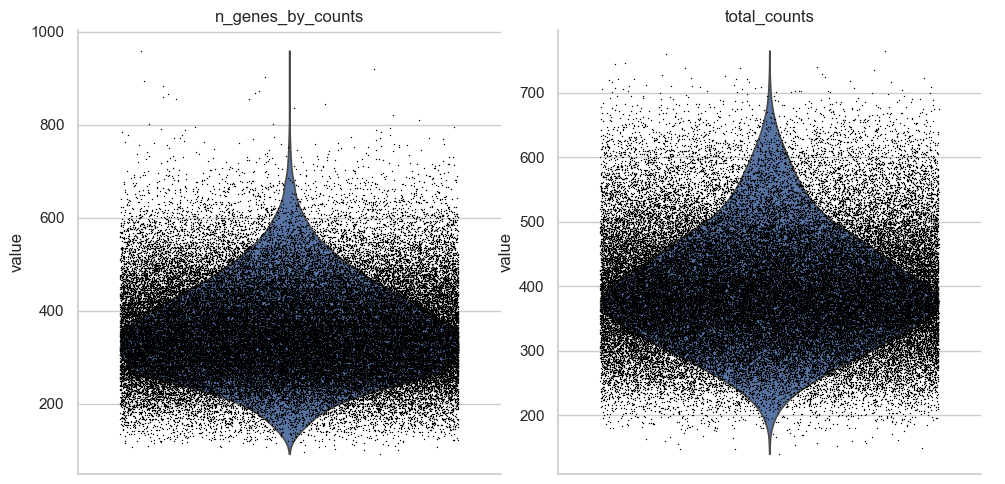

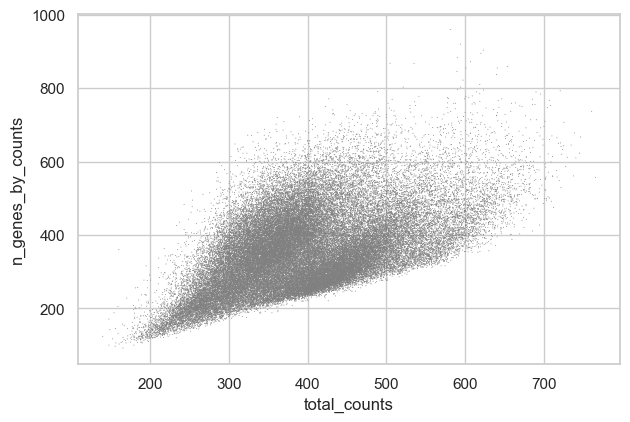

In [ ]:
#Quality control
def show_qc_plots(adata, violin_cols=None, scatter_x=None, scatter_y=None):
    """Show QC plots for AnnData object."""
    sc.pp.calculate_qc_metrics(
    adata,inplace=True, log1p=True)
    sc.pl.violin(adata,violin_cols,jitter=0.4,multi_panel=True)
    sc.pl.scatter(adata, scatter_x, scatter_y)
preprocessing.show_qc_plots(adata_merged, violin_cols=['n_genes_by_counts', 'total_counts'], scatter_x='total_counts', scatter_y='n_genes_by_counts')

In [ ]:
# # #dublet detection     #COMPUTATIONALLY EXPENSIVE - doublets detected
# sc.pp.scrublet(adata_merged)
# print(f"Number of doublets detected: {adata_merged.obs['predicted_doublet'].sum()}")

Number of doublets detected: 0


In [ ]:
#Normalization
adata_merged.layers["raw_counts"] = adata_merged.X.copy()

sc.pp.normalize_total(adata_merged, target_sum=1e4)
sc.pp.log1p(adata_merged) 

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


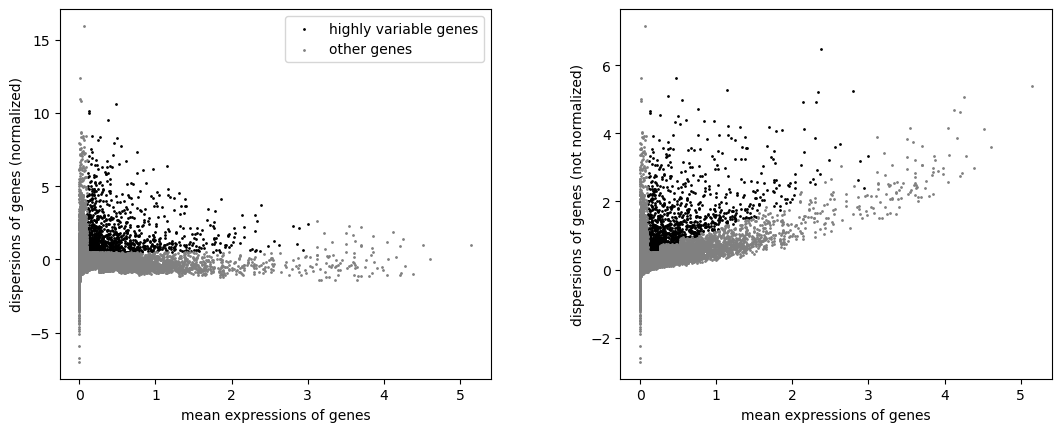

In [ ]:
#Feature selection
adata_merged.layers["pre_feature_selection"] = adata_merged.X.copy()


sc.pp.highly_variable_genes(adata_merged , min_mean=0.1, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata_merged)
adata_merged = adata_merged[:,adata_merged.var.highly_variable]

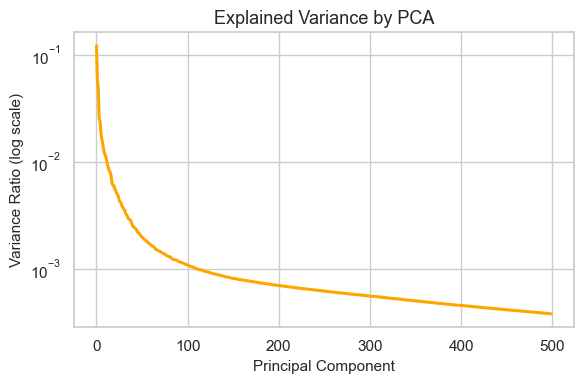

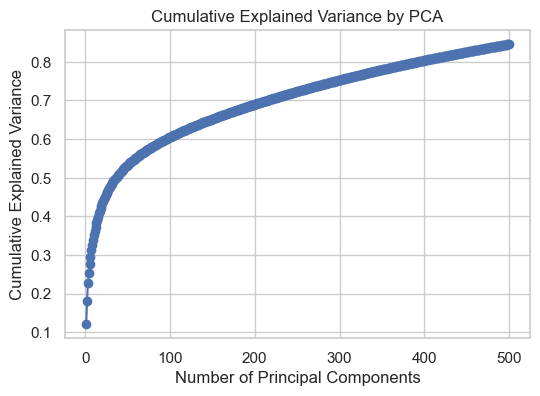

In [ ]:
sc.tl.pca(adata_merged, n_comps=400)
explained_variance = adata_merged.uns['pca']['variance_ratio']
cumulative_variance = explained_variance.cumsum()
sns.set(style="whitegrid")

# Plot 1: Variance Ratio 
plt.figure(figsize=(6, 4))
plt.plot(explained_variance, linewidth=2.2, color="orange")
plt.title("Explained Variance by PCA", fontsize=13)
plt.xlabel("Principal Component", fontsize=11)
plt.ylabel("Variance Ratio (log scale)", fontsize=11)
plt.yscale('log')
plt.tight_layout()
plt.show()

# Plot 2: Cumulative Explained Variance 
plt.figure(figsize=(6,4))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA')
plt.grid(True)
plt.show()

In [ ]:
#UMAP
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)
sc.pl.umap(adata_merged, color = ["Cell_line","TP53_status"]) 

KeyboardInterrupt: 

In [ ]:
#Silhouette score
score = silhouette_score(adata_merged.obsm["X_umap"], adata_merged.obs["dataset"])
print(f"Silhouette score w.r.t. dataset: {score:.3f}")

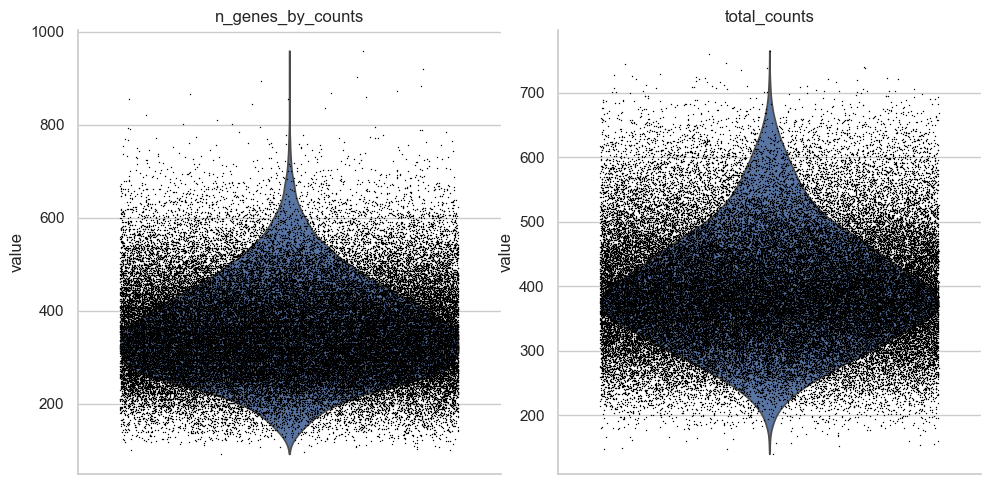

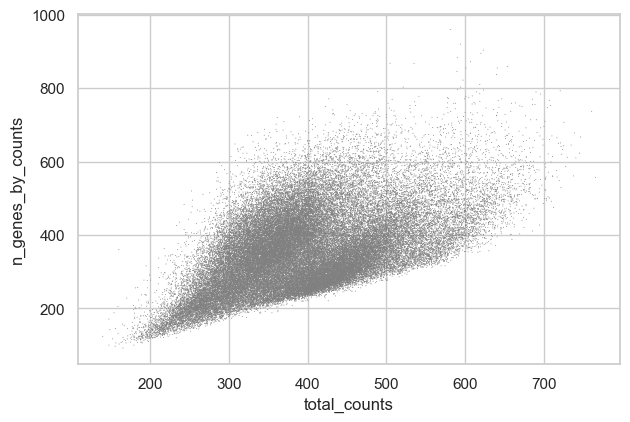

In [ ]:
#Final Quality control
show_qc_plots(adata_merged, violin_cols=['n_genes_by_counts', 'total_counts'], scatter_x='total_counts', scatter_y='n_genes_by_counts')

In [ ]:
final_df = ad.AnnData.to_df(adata_merged)
final_df["mutation_status"] = adata_merged.obs["TP53_status"].values
final_df.head()

,GCLC,LASP1,CYB561,MGST1,MED24,CSDE1,CD9,ANLN,GPRC5A,UFL1,...,IGFBP6,PLAU,LINC00958,GPX3,CALML3,NTS,RSPO3,GTSF1,IGF2,mutation_status
AU565_AAACCAGTTTGG,0.0,0.0,0.000000,2.942830,0.0,0.915272,1.703359,0.000000,0.0,0.915272,...,0.0,0.0,0.0,0.915272,0.0,0.0,0.0,0.000000,0.0,Missense_Mutation
AU565_AAACGTGCAGCG,0.0,0.0,0.806100,2.683124,0.0,1.246548,2.389978,0.806100,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,Missense_Mutation
AU565_AAAGCCACATGC,0.0,0.0,0.000000,2.983100,0.0,0.994898,1.483625,0.000000,0.0,0.994898,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,Missense_Mutation
AU565_AAAGTCGGCTGG,0.0,0.0,0.991473,2.051660,0.0,0.991473,0.991473,0.991473,0.0,0.000000,...,0.0,0.0,0.0,0.991473,0.0,0.0,0.0,0.991473,0.0,Missense_Mutation
AU565_AAAGTGCCTAAA,0.0,0.0,1.622145,3.286096,0.0,2.050686,1.310841,1.310841,0.0,1.622145,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,Missense_Mutation


In [ ]:
print("Value counts per class in mutation_status:")
print(final_df["mutation_status"].value_counts())

Value counts per class in mutation_status:
mutation_status
Missense_Mutation    42280
Nonsense_Mutation     8009
Frame_Shift_Del       5012
Frame_Shift_Ins       3785
Splice_Site           2291
In_Frame_Del          1721
Intron                 931
Silent                 384
In_Frame_Ins           300
Splice_Region          230
Name: count, dtype: int64


In [ ]:
final_df.to_csv("../output/final_preprocessed_data_HVG_.csv")

## Feature Selection: Target genes 

In [ ]:
adata_merged = ad.read_h5ad("../output/merged_gambardella_kinker_common_genes.h5ad")

In [ ]:
#Normalization
adata_merged.layers["raw_counts"] = adata_merged.X.copy()

sc.pp.normalize_total(adata_merged, target_sum=1e4)
sc.pp.log1p(adata_merged) 

In [ ]:
final_df = ad.AnnData.to_df(adata_merged)
final_df["mutation_status"] = adata_merged.obs["TP53_status"].values
final_df.head()

,TSPAN6,DPM1,SCYL3,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,SEMA3F,...,IL25,KRTAP1-4,KRTAP10-3,LINC00378,ARHGEF3-AS1,LINC00492,OCSTAMP,LINC00398,OR52R1,mutation_status
AU565_AAACCAGTTTGG,0.0000,1.385021,0.0,0.915272,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Missense_Mutation
AU565_AAACGTGCAGCG,0.8061,0.000000,0.0,0.806100,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Missense_Mutation
AU565_AAAGCCACATGC,0.0000,1.483625,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Missense_Mutation
AU565_AAAGTCGGCTGG,0.0000,0.000000,0.0,0.991473,0.0,0.0,0.0,0.000000,0.991473,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Missense_Mutation
AU565_AAAGTGCCTAAA,0.0000,1.310841,0.0,0.856391,0.0,0.0,0.0,0.856391,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Missense_Mutation


In [ ]:
# Filter final_df to keep only TP53 target genes and mutation_status, then print summary

target_genes_df = pd.read_excel('../data/TP53target/41388_2017_BFonc2016502_MOESM5_ESM_tab1.xlsx')
target_genes = set(target_genes_df["Gene Symbol"].astype(str).str.upper())
cols_to_keep = [col for col in final_df.columns if col.upper() in target_genes]
if "mutation_status" in final_df.columns:
    cols_to_keep.append("mutation_status")
final_df = final_df[cols_to_keep]
num_genes_kept = len([col for col in cols_to_keep if col != "mutation_status"])
print(f"Numero di geni target TP53 mantenuti: {num_genes_kept}")
print(f"Shape finale del dataframe: {final_df.shape}")


Numero di geni target TP53 mantenuti: 332
Shape finale del dataframe: (64943, 333)


In [ ]:
final_df.to_csv("../output/final_preprocessed_data_target_.csv")

# Preliminary checks: XGBoost on HVG and Target

In [ ]:
#XGBOOST ON HVG DATA
# Carica i dati
df = pd.read_csv("../output/final_preprocessed_data_HVG_.csv", index_col=0)

# Separazione X e y
X = df.drop(columns=["mutation_status"])
y = df["mutation_status"].astype(str)

# Codifica target multiclass
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


# Modello XGBoost multiclass
num_classes = len(le.classes_)
model = xgb.XGBClassifier(
    use_label_encoder=False, 
    eval_metric="mlogloss", 
    objective="multi:softmax", 
    num_class=num_classes
)
model.fit(X_train, y_train) 

# Predizione e valutazione
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy XGBoost (multiclass): {acc:.3f}")
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:05:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy XGBoost (multiclass): 0.758
Classification report:
                   precision    recall  f1-score   support

  Frame_Shift_Del       0.62      0.33      0.43      1003
  Frame_Shift_Ins       1.00      0.74      0.85       757
     In_Frame_Del       1.00      0.69      0.82       344
     In_Frame_Ins       0.00      0.00      0.00        60
           Intron       0.00      0.00      0.00       186
Missense_Mutation       0.75      0.98      0.85      8456
Nonsense_Mutation       0.78      0.24      0.36      1602
           Silent       0.00      0.00      0.00        77
    Splice_Region       0.00      0.00      0.00        46
      Splice_Site       0.24      0.03      0.05       458

         accuracy                           0.76     12989
        macro avg       0.44      0.30      0.34     12989
     weighted avg       0.72      0.76      0.70     12989



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# XGBOOST ON TARGET DATA
# Carica i dati
df = pd.read_csv("../output/final_preprocessed_data_target_.csv", index_col=0)

# Separazione X e y
X = df.drop(columns=["mutation_status"])
y = df["mutation_status"].astype(str)

# Codifica target multiclass
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

#sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Modello XGBoost multiclass
num_classes = len(le.classes_)
model = xgb.XGBClassifier(
    use_label_encoder=False, 
    eval_metric="mlogloss", 
    objective="multi:softmax", 
    num_class=num_classes
)
model.fit(X_train, y_train) #sample_weight=sample_weights

# Predizione e valutazione
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy XGBoost (multiclass): {acc:.3f}")
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:04:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy XGBoost (multiclass): 0.754
Classification report:
                   precision    recall  f1-score   support

  Frame_Shift_Del       0.64      0.31      0.41      1003
  Frame_Shift_Ins       0.97      0.73      0.84       757
     In_Frame_Del       0.99      0.68      0.81       344
     In_Frame_Ins       0.00      0.00      0.00        60
           Intron       0.08      0.01      0.01       186
Missense_Mutation       0.74      0.98      0.85      8456
Nonsense_Mutation       0.82      0.22      0.35      1602
           Silent       0.00      0.00      0.00        77
    Splice_Region       0.00      0.00      0.00        46
      Splice_Site       0.29      0.03      0.06       458

         accuracy                           0.75     12989
        macro avg       0.45      0.30      0.33     12989
     weighted avg       0.73      0.75      0.70     12989



/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


We see that the classifier trained on the TP53 Target Genes performs really similar to the one trained on the HVG. This, toghether with the results found in the binary classifier (https://github.com/tommasoravasio/scRNAseq-GNN-binary-tp53), allows us to conclude that we can proceed the experiment with only the Target genes without loss of information or generalization capability.

# Graph construction

shape del train test: (51954, 333) 
shape del test set: (12989, 333)
Percentage of non-zero values in the correlation matrix: 0.009598635505878937


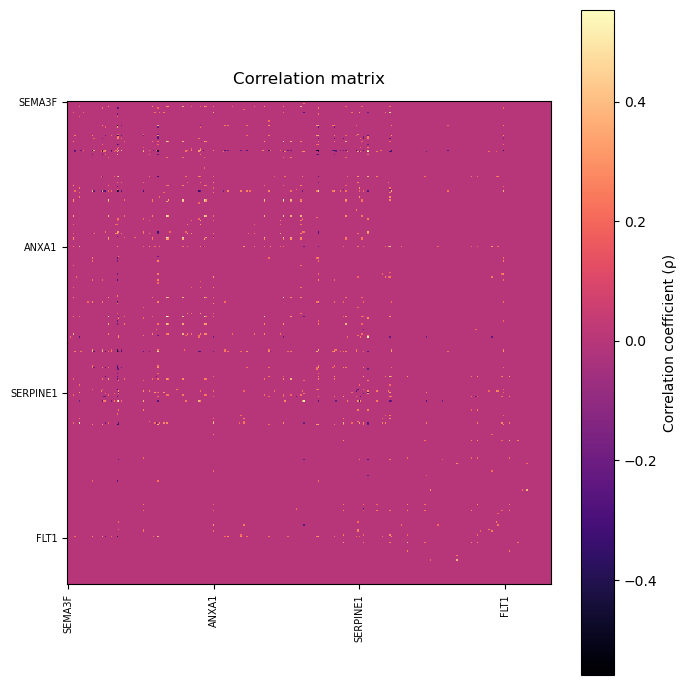

In [8]:
#Construction of the correlation matrix
df_target = pd.read_csv("../output/final_preprocessed_data_target_.csv", index_col=0)
train_df, test_df = graph_constructor.train_test_split(df_target, test_size=0.2, random_state=42)
print(f"shape del train test: {train_df.shape} \nshape del test set: {test_df.shape}")
mat=graph_constructor.build_correlation_matrix(train_df.iloc[:,:-1], corr_threshold=0.2, p_value_threshold=0.05) 
graph_constructor.check_percentage_of_zeros(mat)
graph_constructor.plot_the_correlation_matrix_colored(train_df, mat)

Number of nodes: 332
Number of edges: 1058
Number of features per node: 1
Has isolated nodes: True
Has self-loops: False
Is undirected: True


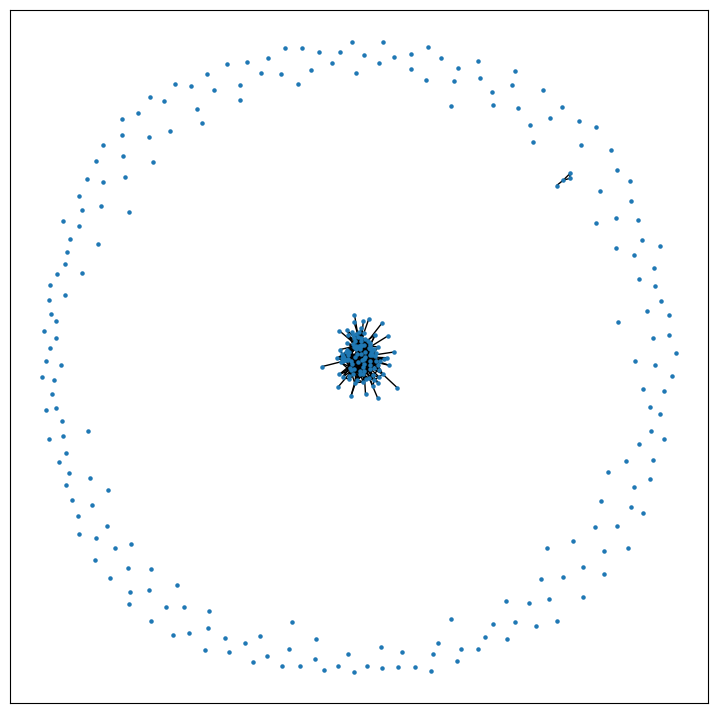

In [13]:
#LOAD THE GRAPHS OBTAINED ON THE CLUSTER FOR TARGET
first_train_batch = torch.load("../output/graphs_target_None/train/batch_000.pt", weights_only=False)
first_test_batch = torch.load("../output/graphs_target_None/test/batch_000.pt", weights_only=False)


assert graph_constructor.check_graph_structure(first_train_batch), "The graphs in the train set do not have the same structure."
assert graph_constructor.check_graph_structure(first_test_batch), "The graphs in the test set do not have the same structure."
graph_constructor.get_info_and_plot_graph(first_train_batch)

Number of nodes: 1241
Number of edges: 67768
Number of features per node: 1
Has isolated nodes: True
Has self-loops: False
Is undirected: True


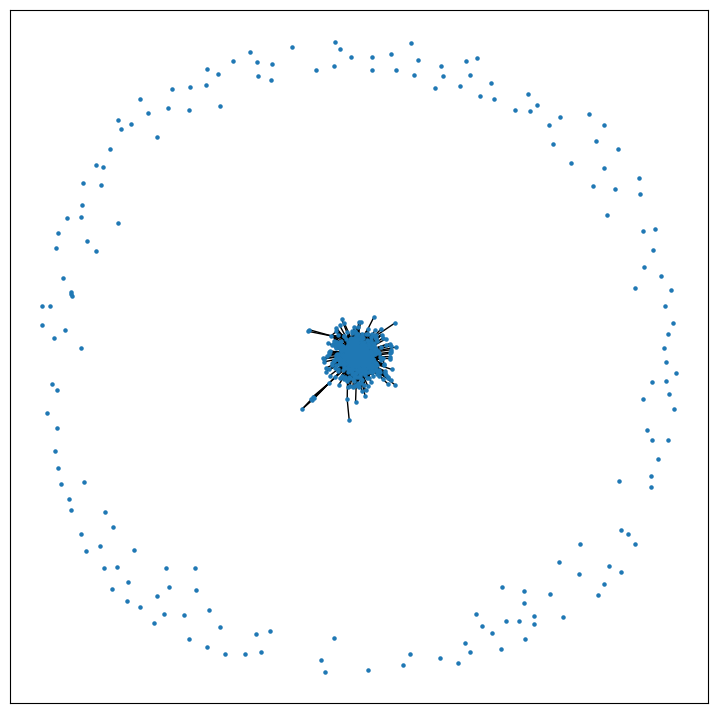

In [14]:
#LOAD THE GRAPHS OBTAINED ON THE CLUSTER FOR HVG
first_train_batch = torch.load("../output/graphs_HVG_None/train/batch_000.pt", weights_only=False)
first_test_batch = torch.load("../output/graphs_HVG_None/test/batch_000.pt", weights_only=False)


assert graph_constructor.check_graph_structure(first_train_batch), "The graphs in the train set do not have the same structure."
assert graph_constructor.check_graph_structure(first_test_batch), "The graphs in the test set do not have the same structure."
graph_constructor.get_info_and_plot_graph(first_train_batch)

# Model comparison and results

## TP53 Target genes

### GCN

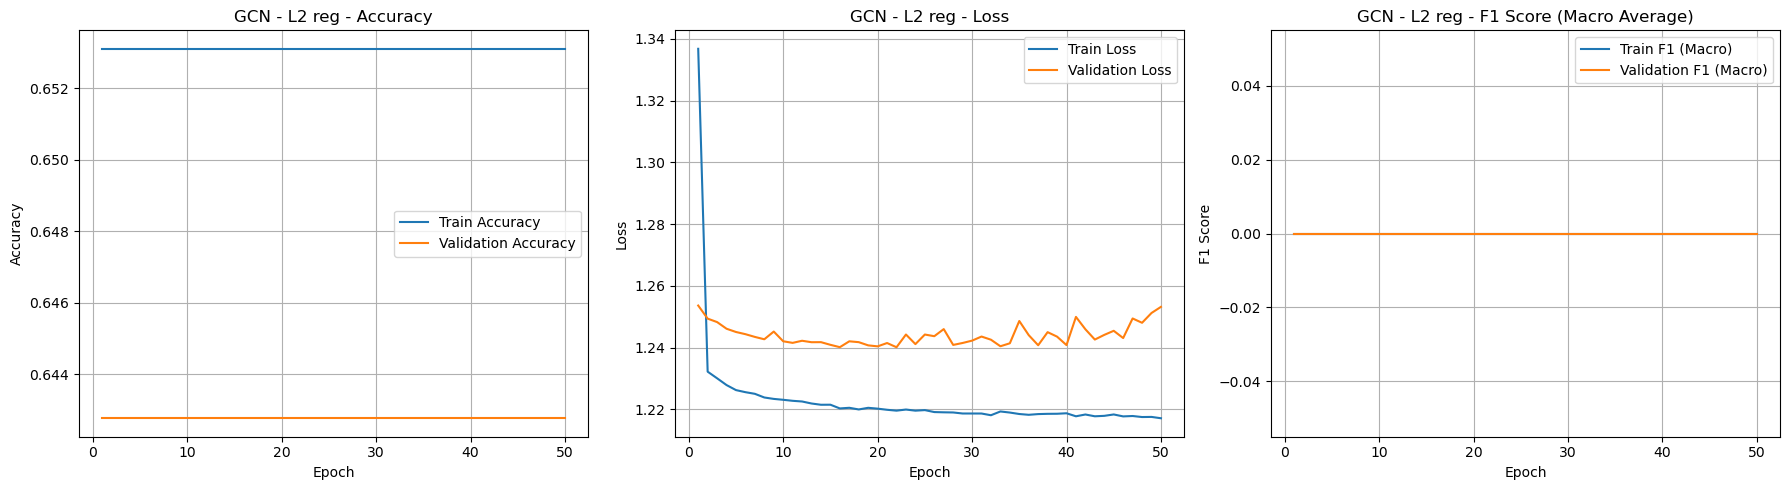

In [2]:
model_comparison.plot_training_curves("../Results/target/gcn_results/AdamW_gcn/training_log.csv", model_name = "GCN - L2 reg")

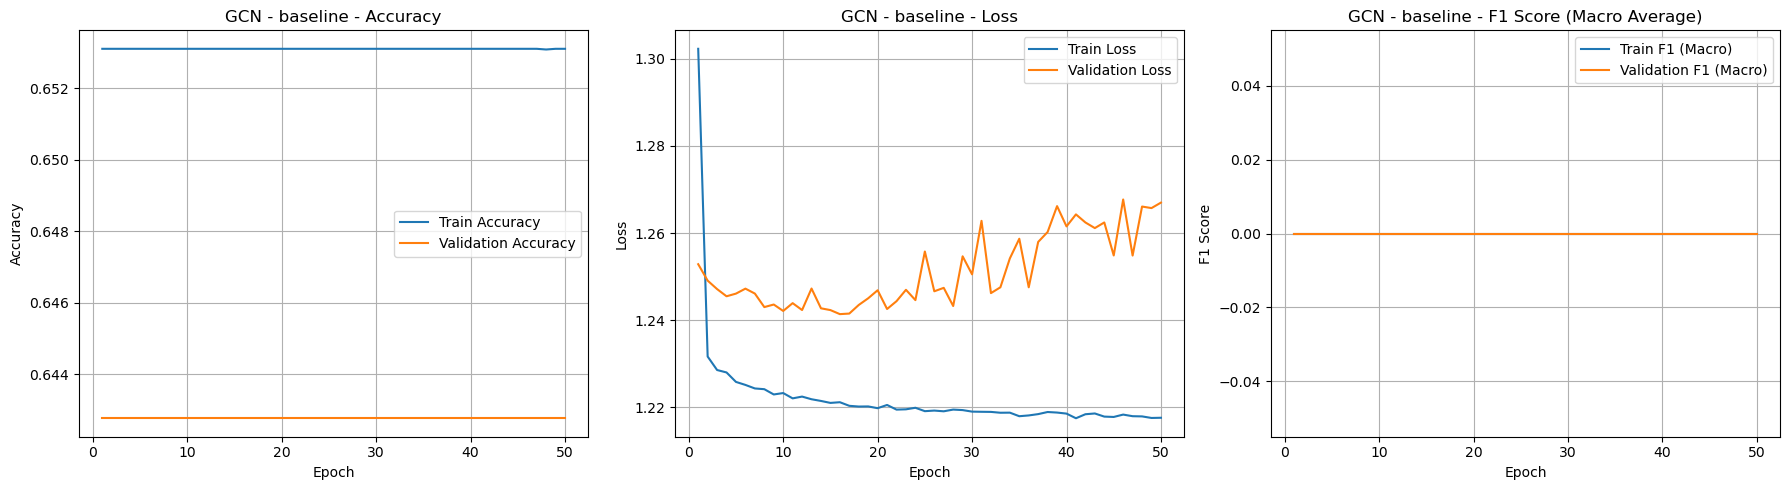

In [3]:
model_comparison.plot_training_curves("../Results/target/gcn_results/baseline_gcn/training_log.csv", model_name = "GCN - baseline")

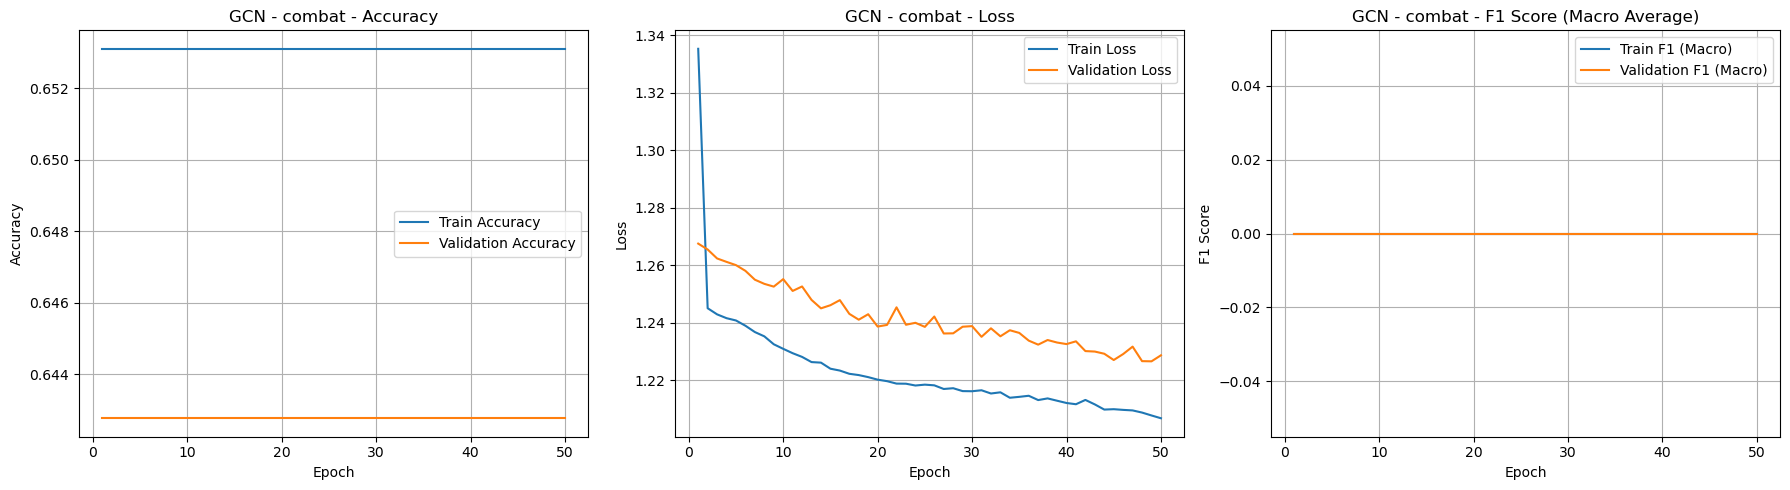

In [4]:
model_comparison.plot_training_curves("../Results/target/gcn_results/combat_gcn/training_log.csv", model_name = "GCN - combat")

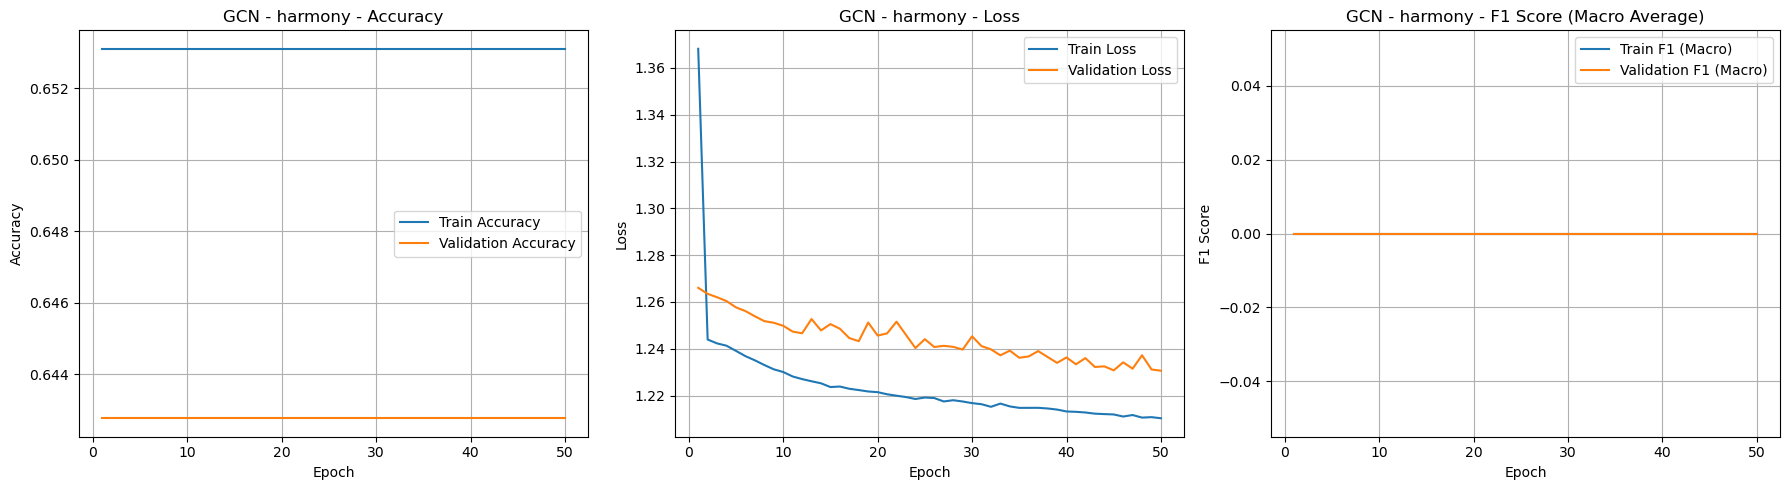

In [5]:
model_comparison.plot_training_curves("../Results/target/gcn_results/harmony_gcn/training_log.csv", model_name = "GCN - harmony")

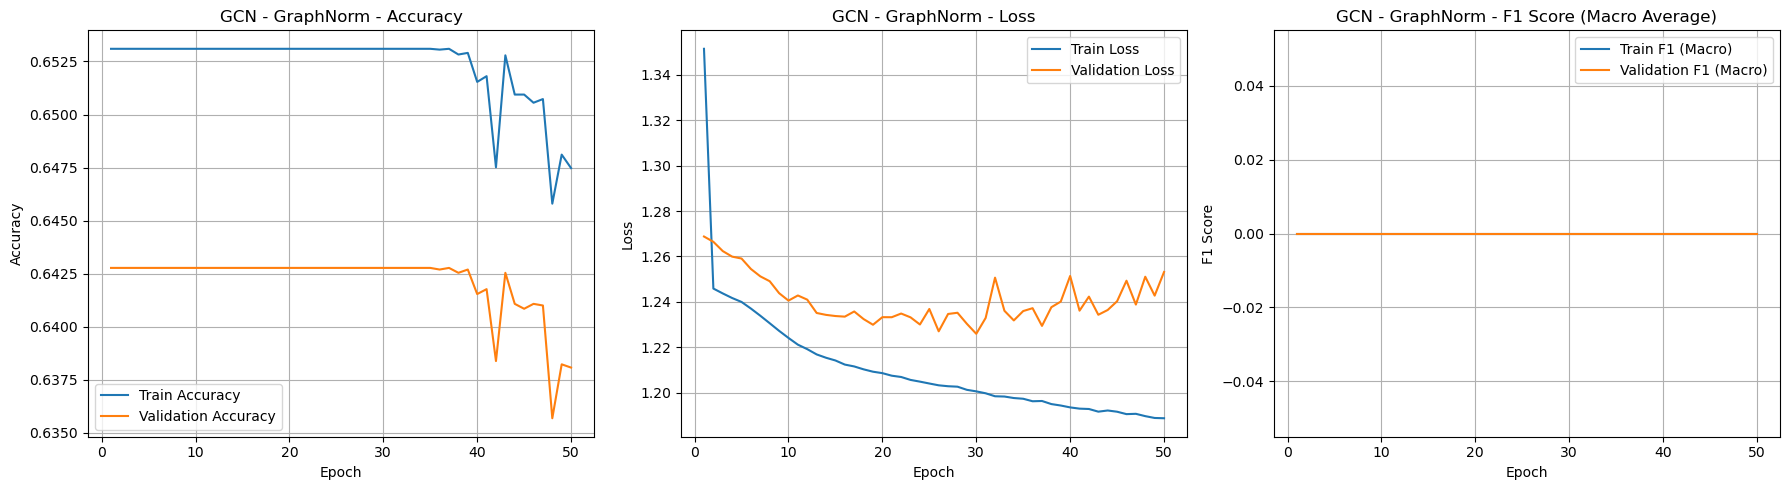

In [6]:
model_comparison.plot_training_curves("../Results/target/gcn_results/GraphNorm_gcn/training_log.csv", model_name = "GCN - GraphNorm")

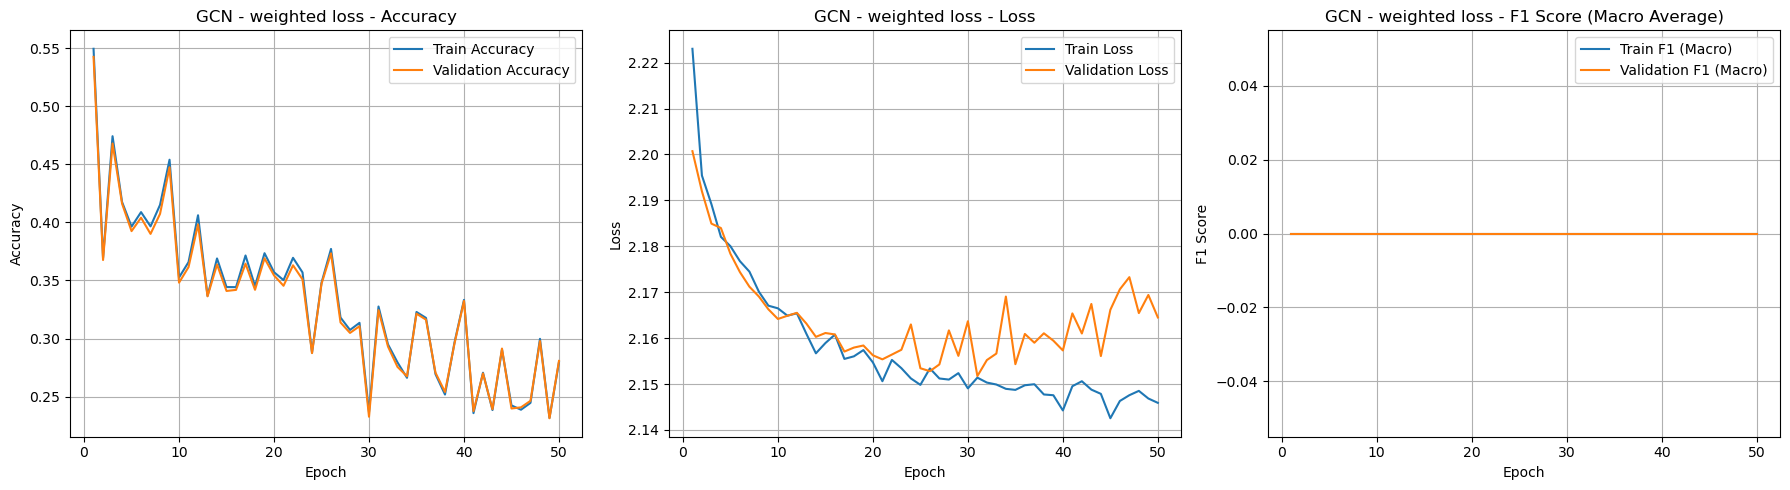

In [7]:
model_comparison.plot_training_curves("../Results/target/gcn_results/weight_gcn/training_log.csv", model_name = "GCN - weighted loss")

## GAT

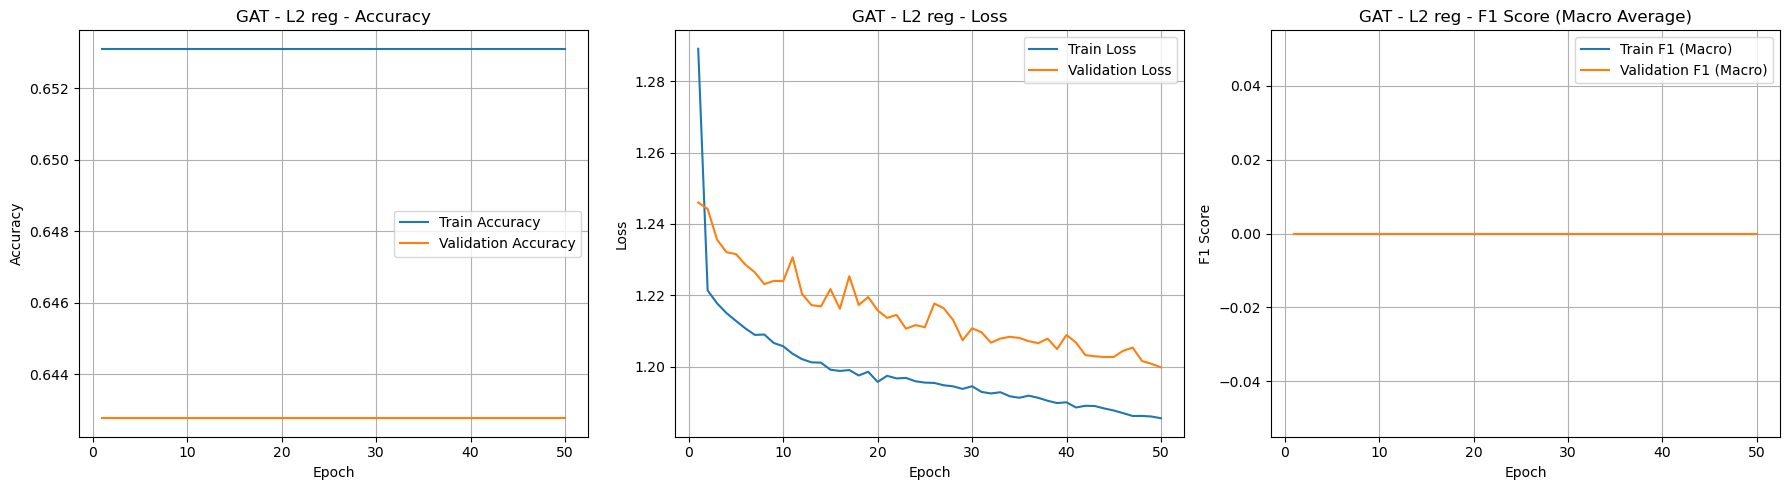

In [8]:
model_comparison.plot_training_curves("../Results/target/gat_results/AdamW_gat/training_log.csv", model_name = "GAT - L2 reg")

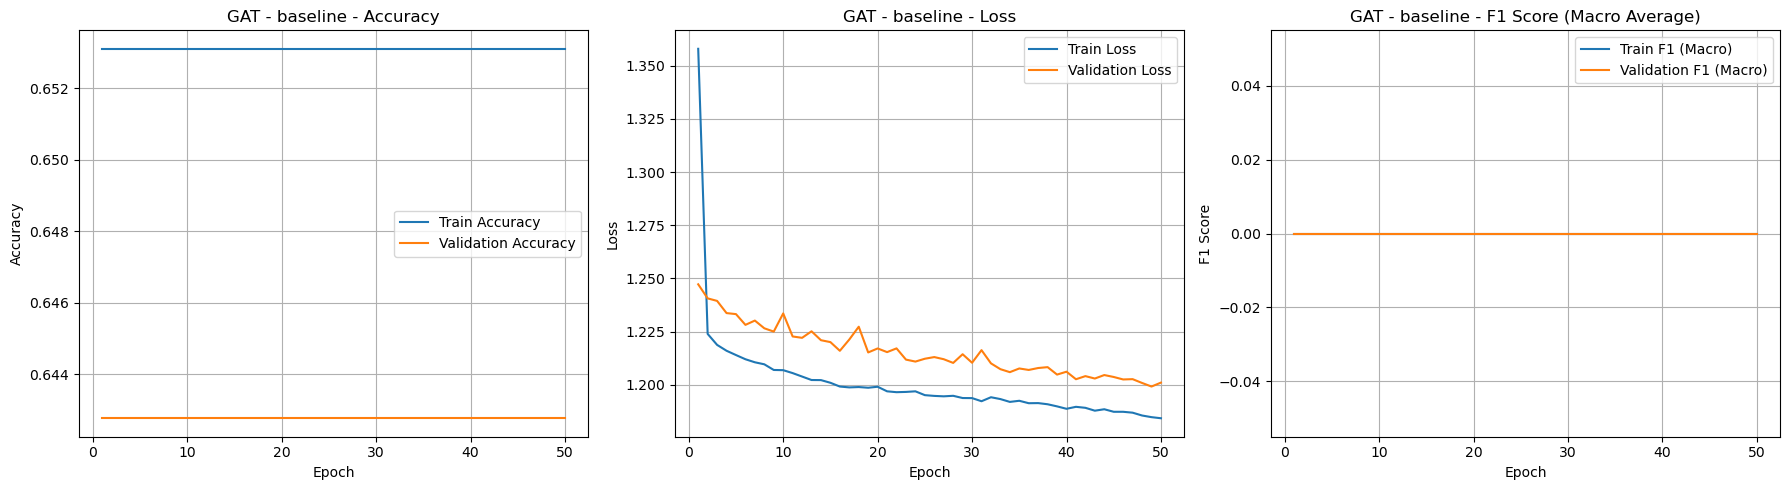

In [9]:
model_comparison.plot_training_curves("../Results/target/gat_results/baseline_gat/training_log.csv", model_name = "GAT - baseline")

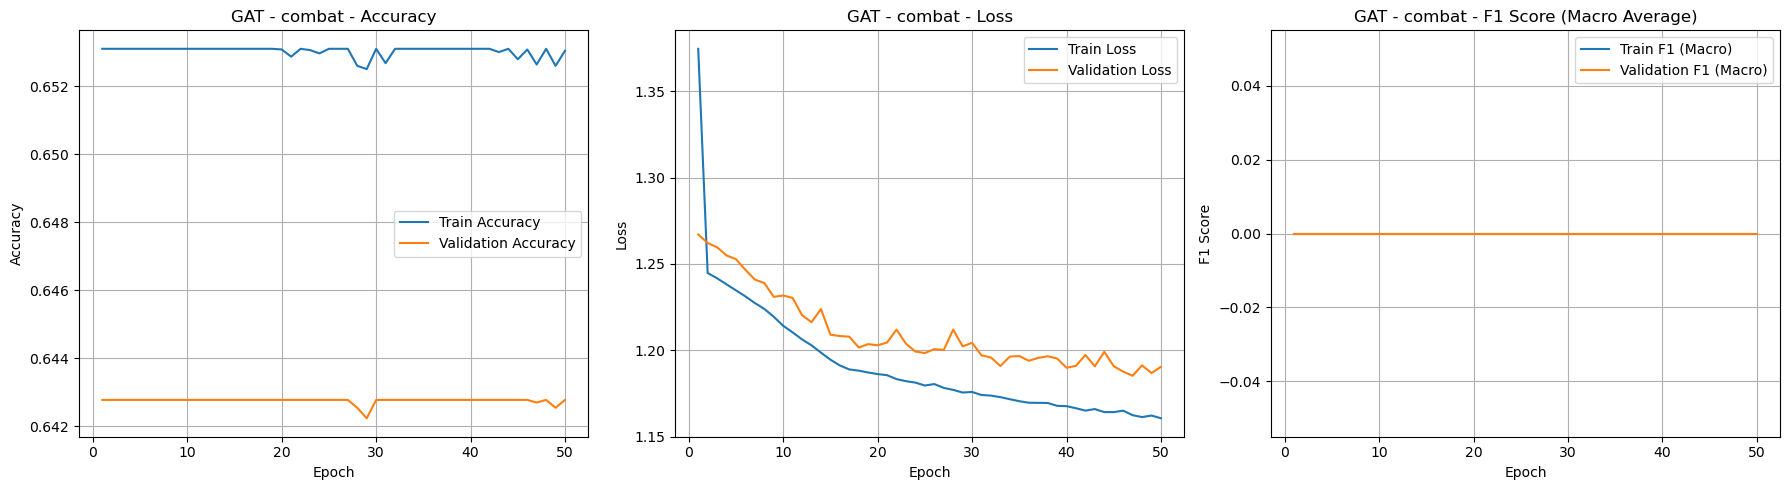

In [10]:
model_comparison.plot_training_curves("../Results/target/gat_results/combat_gat/training_log.csv", model_name = "GAT - combat")

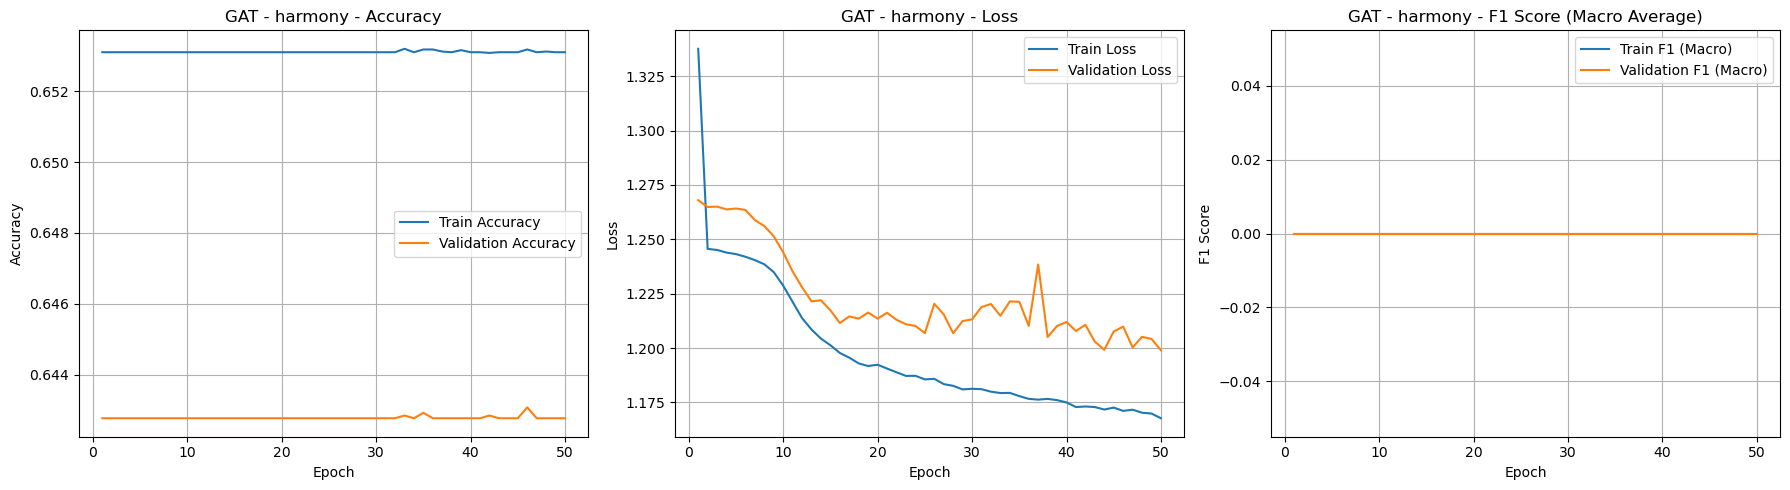

In [11]:
model_comparison.plot_training_curves("../Results/target/gat_results/harmony_gat/training_log.csv", model_name = "GAT - harmony")

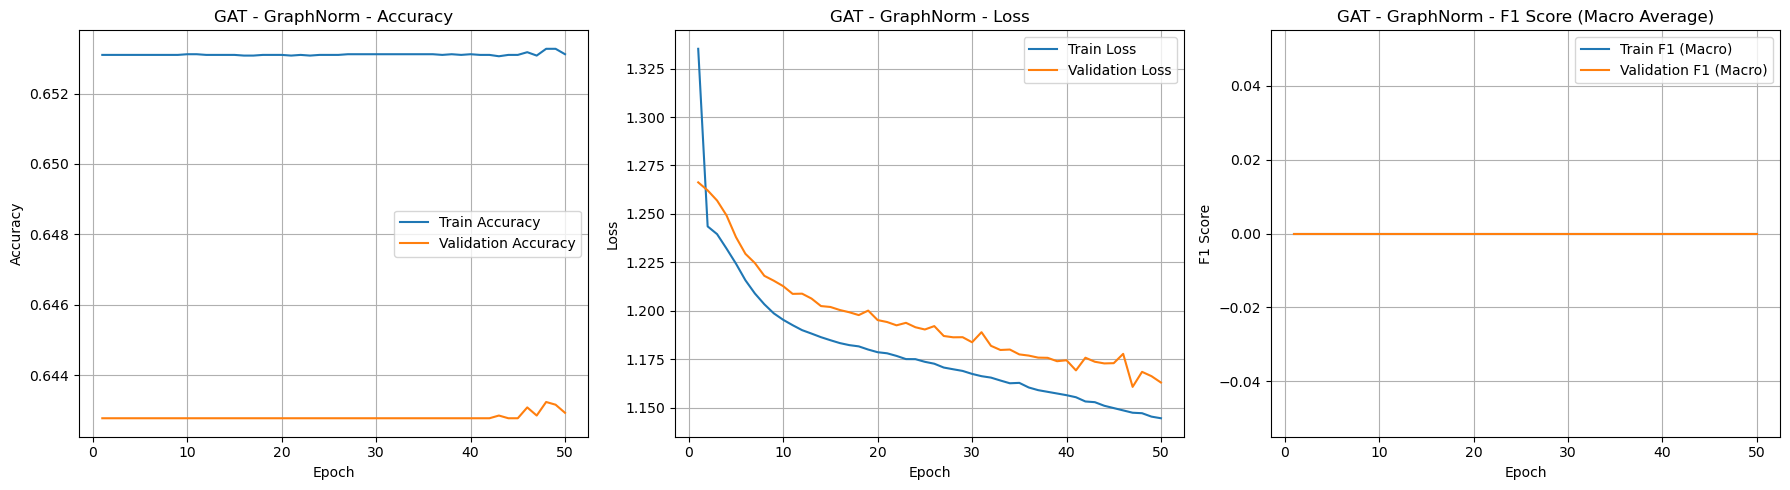

In [12]:
model_comparison.plot_training_curves("../Results/target/gat_results/GraphNorm_gat/training_log.csv", model_name = "GAT - GraphNorm")

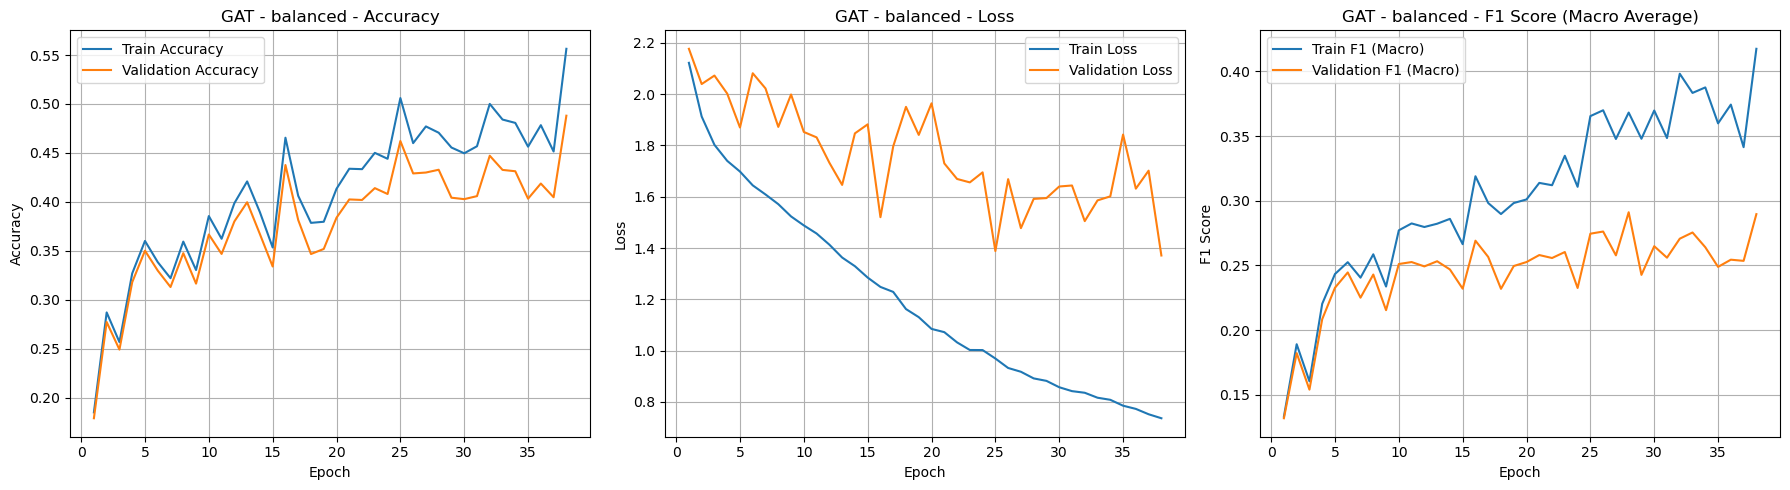

In [ ]:
model_comparison.plot_training_curves("../Results/target/gat_results/aggressive_balanced_GAT/training_log.csv", model_name = "GAT - aggressive balanced")